# Background

This notebook applies a neural networks to predict risk for breast cancer using a [dataset at UCI](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

The dataset includes 699 observations from 569 people:

```
$ wc -l *
  140 breast-cancer.cv
  140 breast-cancer.test
  419 breast-cancer.train
  699 total
```

The dataset provides information about the patients' tumors including:
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry 
* fractal dimension ("coastline approximation" - 1)

and then provides information about whether the tumor turned out to be benign or malignant.


In [284]:
# NumPy is the fundamental package for scientific computing with Python.
import numpy as np

In [285]:
def theta_init(in_size, out_size, epsilon = 0.12):
    return np.random.rand(in_size + 1, out_size) * 2 * epsilon - epsilon

In [286]:
def sigmoid(x):
    return np.divide(1.0, (1.0 + np.exp(-x)))
def sigmoid_derivative(x):
    return np.multiply(x, (1.0 - x))

In [287]:
def mean_squared_error(X):
    return np.power(X, 2).mean(axis=None)

In [288]:
def nn_train(X, y, desired_error = 0.001, max_iterations = 10000, hidden_nodes = 7):
    
    m = X.shape[0]
    input_nodes = X.shape[1]
    output_nodes = y.shape[1]
    
    a1 = np.insert(X, 0, 1, axis=1)
    theta1 = theta_init(input_nodes, hidden_nodes)
    theta2 = theta_init(hidden_nodes, output_nodes)
    
    for x in range(0, max_iterations):
        # Feedforward
        a2 = np.insert(sigmoid(a1.dot(theta1)), 0, 1, axis=1)
        a3 = sigmoid(a2.dot(theta2))
        
        # Calculate error using backpropagation
        a3_delta = np.subtract(y, a3)
        mse = mean_squared_error(a3_delta)
        if mse <= desired_error:
            print "Achieved requested MSE %f at iteration %d" % (mse, x)
            break
        a2_error = a3_delta.dot(theta2.T)
        a2_delta = np.multiply(a2_error, sigmoid_derivative(a2))
        
        # Update thetas to reduce the error on the next iteration
        theta2 += np.divide(a2.T.dot(a3_delta), m)
        theta1 += np.delete(np.divide(a1.T.dot(a2_delta), m), 0, 1)
        
    return (theta1, theta2)

In [289]:
def nn_predict(X, theta1, theta2):
    a2 = sigmoid(np.insert(X, 0, 1, axis=1).dot(theta1))
    return sigmoid(np.insert(a2, 0, 1, axis=1).dot(theta2))

In [290]:
def load_data(filename):
    import csv
    with open(filename, 'rb') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        return np.array([[-1 if el == '?' else int(el) for el in r] for r in csvreader])

In [291]:
def from_raw_to_y_vector(raw_data):
    # The last column is '2' for benign and '4' for malignant tumors
    # Converting to 0 (false) for benign and 1 (true) for malignant.
    return np.array([[0 if x == 2 else 1] for x in raw_data[:, 10]])

In [292]:
raw_train_data = load_data("data/breast-cancer.train")
# Ignore the ID in the first column and the outcome in the last column
X = raw_train_data[:, 1:9]
y = from_raw_to_y_vector(raw_train_data)

# Train the neural network
%time (theta1, theta2) = nn_train(X, y)

# Run cross-validation on the data
raw_cv_data = load_data("data/breast-cancer.cv")
X_cv = raw_cv_data[:, 1:9]
y_cv = from_raw_to_y_vector(raw_cv_data)
y_calc = nn_predict(X_cv, theta1, theta2)
y_diff = np.subtract(y_calc, y_cv)
print "The MSE for our cross validation set is %f" % (mean_squared_error(y_diff))

CPU times: user 1.76 s, sys: 2.73 ms, total: 1.76 s
Wall time: 1.76 s
The MSE for our cross validation set is 0.038745


The MSE for our test set is 0.046847


<IPython.core.display.Javascript object>


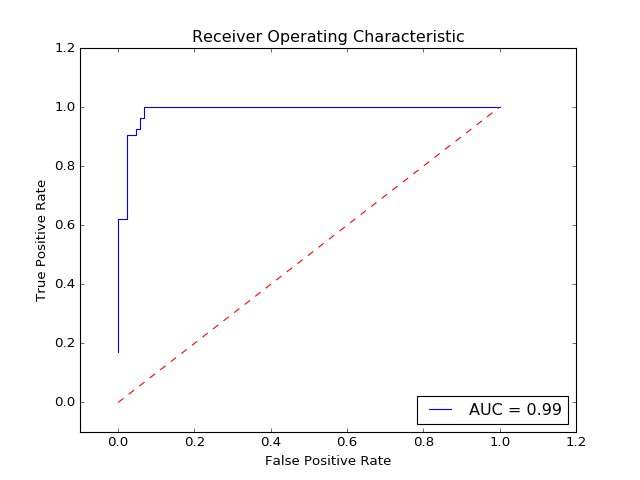

In [293]:
# Run on the test set
raw_test_data = load_data("data/breast-cancer.test")
X_test = raw_test_data[:, 1:9]
y_test = from_raw_to_y_vector(raw_test_data)
y_calc = nn_predict(X_test, theta1, theta2)
y_diff = np.subtract(y_calc, y_test)
print "The MSE for our test set is %f" % (mean_squared_error(y_diff))

# Print ROC curves
%matplotlib notebook
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_calc, pos_label=1)
roc_auc = metrics.roc_auc_score(y_test, y_calc, average='macro', sample_weight=None)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

With this simple neural network, we're able to achieve a high area under the curve (AUC).